The work below relates to sections **Hot polaron states** and **Carrier cooling: heat transfer to the lattice** of the 2017 publication _Slow cooling of hot polarons in halide perovskite solar cells_. The notebook was written by Lucy D. Whalley.

In [17]:
# import libraries
import math
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as integrate
%matplotlib inline

In [3]:
# constants in SI
m = 9.10938291E-31 # mass of electron
q = 1.60217657E-19 # charge of electron
ε = 8.85418782E-12 # permittivity of free space
h = 6.62606957E-34 # plancks magical number
hbar = 1.054571800E-34 # reduced planck
Rydberg = 2.1787E-18 # Rydberg energy (in joules)
avogadro = 6.02214179E23

# units in SI
Å = 1E-10 # m to angstrom
k = 1.38064852E-23

In [19]:
# matplotlib parameters
mpl.rcParams.update({'font.size': 24})
plt.rcParams["font.family"] = "serif"
mpl.rcParams['axes.linewidth'] = 1 
mpl.rcParams['xtick.major.width'] = 1 
mpl.rcParams['ytick.major.width'] = 1 

### Calculate polaron temperature in CH<sub>3</sub>NH<sub>3</sub>PbI<sub>3</sub> (MAPI) as a function of polaron radius and incoming photon energy

- Using polaron theory we have calculated the radius of the polaron (26.8Å). This provides an upper limit as disorder will increase localisation of the charge carrier. 
- We assume equipartition of the above bandgap energy between electron and hole. Near-UV excitation at 4eV gives a maximum energy of 1.2eV which can be transferred to the polaron.
- The heat capacity can be calculated from the bulk phonon density of states

The information above is enough to calculate the polaron temperature, as is done below.

In [5]:
def polaron_temperature(radius,energy,heat_capacity,lattice_constant):
    volume_polaron = (4/3)*math.pi*(radius**3)
    volume_one_mole = avogadro*((lattice_constant)**3) 
    moles = volume_polaron / volume_one_mole
    temperature = energy / (heat_capacity*moles)
    return temperature # in K measured above bulk temperature

heat capacity is 120.60668096444826


(array([-2.,  0.,  2.,  4.,  6.,  8.]), <a list of 6 Text yticklabel objects>)

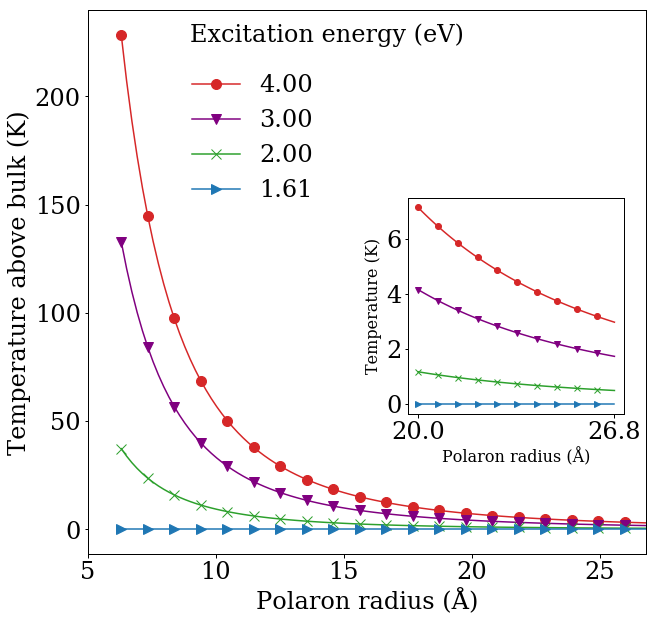

In [20]:
# MAPI lattice constant from neutron diffraction, doi:10.1038/srep35685
d = 6.306*Å
# MAPI bandgap from experimental (300 K), doi:10.7567/APEX.7.032302
ε_g = 1.61
# MAPI heat capacity
heat_capacity = 1.25 # value calculated from bulk phonon density of states, meV/unit cell/K
heat_capacity = (1.25/1000)*q # J/unit cell/K
heat_capacity = heat_capacity*avogadro # J/mol/K
print("heat capacity is %s"%heat_capacity)

photon_energies = [(x - ε_g)*q for x in [1.61,2,3,4]]
colours = ["#d62728","purple","#2ca02c","#1f77b4"]
marker = ['o','v','x','>']
## PLOT
fig = plt.figure(figsize=(10,10))
counter = 0
for energy in reversed(photon_energies):
    temperature = []
    for radius in np.linspace(d,26.8*Å,100):
        temperature.append(polaron_temperature(radius,energy/2,heat_capacity,d)) # divide by two as half goes to electron
    plt.plot((np.linspace(d,26.8*Å,100))/Å,temperature,label="{:.2f}".format((energy/q)+ε_g),color = colours[counter],marker=marker[counter],markevery=5,markersize=10)
    counter += 1
plt.xlabel("Polaron radius (Å)")
plt.xlim([6.306,26.8])
plt.xticks([5,10,15,20,25]) 
plt.ylabel("Temperature above bulk (K)")
plt.legend(loc=(0.17,0.63),frameon=False)
plt.text(9,225,"Excitation energy (eV)")

a = plt.axes(([.57, .32, .3, .3]))
counter = 0    
for energy in reversed(photon_energies) :
    temperature = []
    for radius in np.linspace(20*Å,26.8*Å,100):
        temperature.append(polaron_temperature(radius,energy/2,heat_capacity,d))
    plt.plot((np.linspace(20*Å,26.8*Å,100))/Å,temperature,color = colours[counter],marker=marker[counter], markevery=10)
    counter += 1
plt.xticks([20,26.8]) 
plt.ylabel("Temperature (K)",fontsize=16)
plt.xlabel("Polaron radius (Å)",fontsize=16)
plt.yticks()

#plt.savefig("TempVsRadius.png",bbox_inches='tight',format="png",dpi=500)


### Calculate Polaron temperature as a function of time and material diffusivity

- We consider individual phonon quanta being absorbed into isolated hot polarons (low fluence limit)
- We consider the polaron as a hot sphere in a continuum of ambient temperature material, this allows us to calculate temperature as a function of time using the classical heat diffusion equation.

In [7]:
def crank_diffusion_sphere(initial_temperature,polaron_radius,D,position,time):
    # This is the expression for heat diffusion from a hot sphere - taken from Crank's The Mathematics of Diffusion (ISBN: 0198534116)
    return 0.5*initial_temperature*(math.erf((polaron_radius+position)/np.sqrt(4*D*time)) + math.erf((polaron_radius-position)/np.sqrt(4*D*time))) - ((initial_temperature/position)*np.sqrt(D*time/math.pi)*(math.exp(-((polaron_radius-position)**2)/(4*D*time))-math.exp(-((polaron_radius+position)**2)/(4*D*time))))

In [8]:
def diffusivity(thermal_conductivity, d, molecular_weight,heat_cap):
    # diffusivity = thermal_conductivity / (density*heat capacity)
    density = (molecular_weight/avogadro) / (d**3) # g/m^3 
    heat_capacity_g = heat_capacity / molecular_weight # convert heat capacity to J/g/K
    return thermal_conductivity / (density*heat_capacity_g) # m^2/s

In [9]:
## polaron properties
polaron_radius = 26.8*Å
initial_temperature = 3 # temperature for a polaron in MAPI with a radius of 26.8Å, excited by 1.2eV
time_steps = np.logspace(-15,-8,10000)

In [10]:
## MAPI
d = 6.306*Å # m
molecular_weight = 619.98 # g/mole
heat_capacity = 120 # J/mol/k, see calculation above
thermal_conductivity = 0.05 # W.m-1.k-1, taken from https://doi.org/10.1103/PhysRevB.94.220301
D = diffusivity(thermal_conductivity,d,molecular_weight,heat_capacity)
print ("Diffusivity is %E"%D)

temp_MAPI = []
for time in time_steps:
    data = []
    # take a weighted average temperature across the polaron
    for position in (np.linspace(1E-20,+polaron_radius,10)):
        data.append(crank_diffusion_sphere(initial_temperature,polaron_radius,D,position,time))
    w = np.multiply(np.linspace(0,+polaron_radius,10),np.linspace(0,+polaron_radius,10))
    temp_MAPI.append(np.average(data,weights=w))


Diffusivity is 6.292187E-08


In [11]:
## CdTe
d = 6.48*Å
molecular_weight = 240.01 # g/mole
heat_capacity = 38.9  # J/mol/k, from experimental
thermal_conductivity = 9  # W.m-1.k-1, taken from https://doi.org/10.1103/PhysRevB.94.220301
D = diffusivity(thermal_conductivity,d,molecular_weight,heat_capacity)
print ("Diffusivity is %E"%D)

temp_CdTe = []
for time in time_steps:
    data = []
    for position in (np.linspace(1E-20,+polaron_radius,10)):
        data.append(crank_diffusion_sphere(initial_temperature,polaron_radius,D,position,time))
    w = np.multiply(np.linspace(0,+polaron_radius,10),np.linspace(0,+polaron_radius,10))
    temp_CdTe.append(np.average(data,weights=w))

Diffusivity is 3.791132E-05


In [12]:
## GaAs
d = 5.65*Å
molecular_weight = 144.645 # g/mole
heat_capacity = 47 # J/mol/K, from experimental
thermal_conductivity = 38 # W.m-1.k-1, taken from https://doi.org/10.1103/PhysRevB.94.220301
D = diffusivity(thermal_conductivity,d,molecular_weight,heat_capacity)
print ("Diffusivity is %E"%D)

temp_GaAs = []
for time in time_steps:
    data = []
    for position in (np.linspace(1E-20,+polaron_radius,10)):
        data.append(crank_diffusion_sphere(initial_temperature,polaron_radius,D,position,time))
    w = np.multiply(np.linspace(0,+polaron_radius,10),np.linspace(0,+polaron_radius,10))
    temp_GaAs.append(np.average(data,weights=w))

Diffusivity is 8.781770E-05


In [13]:
## CsPbI3
d = 6.29*Å 
molecular_weight = 720.82 # g/mole
heat_capacity = 31 # J/mol/K, from phonon DOS
thermal_conductivity = 0.5 # W.m-1.k-1, as calculated in the paper
D = diffusivity(thermal_conductivity,d,molecular_weight,heat_capacity)
print ("Diffusivity is %E"%D)

temp_CsPbI3 = []
for time in time_steps:
    data = []
    for position in (np.linspace(1E-20,+polaron_radius,10)):
        data.append(crank_diffusion_sphere(initial_temperature,polaron_radius,D,position,time))
    w = np.multiply(np.linspace(0,+polaron_radius,10),np.linspace(0,+polaron_radius,10))
    temp_CsPbI3.append(np.average(data,weights=w))

Diffusivity is 2.417192E-06


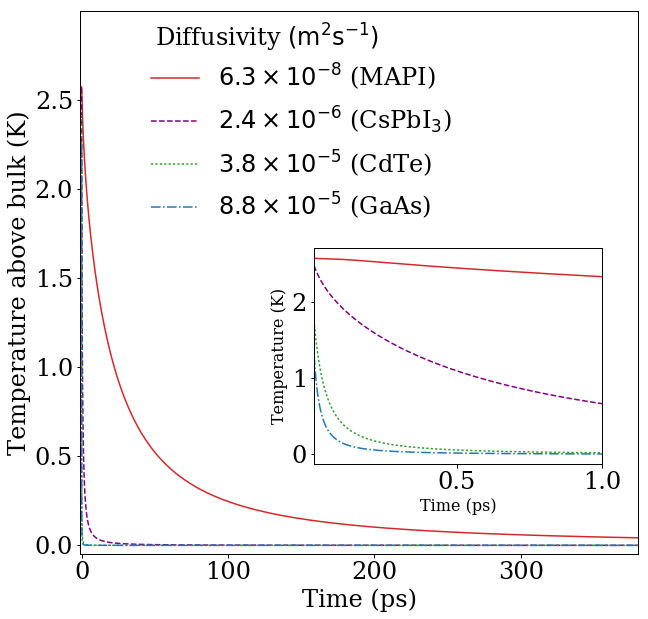

In [21]:
# PLOT
fig = plt.figure(figsize=(10,10))
plt.plot(time_steps/1E-12,temp_MAPI,color="#d62728",ls="-")#,linewidth="2")
plt.plot(time_steps/1E-12,temp_CsPbI3,color="purple",ls="--")
plt.plot(time_steps/1E-12,temp_CdTe,color="#2ca02c",ls=":")
plt.plot(time_steps/1E-12,temp_GaAs,color="#1f77b4",ls="-.")
plt.text(50.0,2.8,r"Diffusivity $(\mathrm{m}^2\mathrm{s}^{-1})$")
plt.xlabel("Time (ps)")
plt.xlim([-1,380])
plt.xticks([0,100,200,300])
plt.ylabel("Temperature above bulk (K)")
plt.ylim([-0.05,3])
plt.yticks([0,0.5,1,1.5,2,2.5])

a = plt.axes(([.45, .25, .4, .3]))
plt.plot(time_steps/1E-12,temp_MAPI,label=r"$6.3\times 10^{-8}$ (MAPI)",color="#d62728",ls="-")#,linewidth="2")
plt.plot(time_steps/1E-12,temp_CsPbI3,label=r"$2.4\times 10^{-6}$ (CsPbI$_3$)",color="purple",ls="--")
plt.plot(time_steps/1E-12,temp_CdTe,label=r"$3.8\times 10^{-5}$ (CdTe)",color="#2ca02c",ls=":")#,linewidth="2")
plt.plot(time_steps/1E-12,temp_GaAs,label=r"$8.8\times 10^{-5}$ (GaAs)",color="#1f77b4",ls="-.")#,linewidth="2")
plt.xlabel("Time (ps)",fontsize=16)
plt.xlim([0.01,1])
plt.xticks([0.5,1.0])
plt.ylabel("Temperature (K)",fontsize=16)
plt.legend(loc=(-0.6,1.08),frameon=False)

#plt.savefig("TempVsTime.png",bbox_inches='tight',format="png",dpi=500)